# Simulating a quantum circuit using the density matrix formalism


In [1]:
import numpy as np
import matplotlib.pyplot as plt

# helper functions for manipulating and visualizing density matrices
from src.visualizers.density_matrix import density_matrix_bars
from src.backends.density_matrix.functions import (
    state_ketz0,
    state_ketz1,
    tensor,
    ket2dm,
    partial_trace,
    fidelity,
)

First, we create the quantum circuit by adding gates, specifying the registers (quantum and classical) that they act on.

In [2]:
from src.circuit import CircuitDAG

# import the relevant operations to add to the circuit
from src.ops import Hadamard, CNOT, MeasurementCNOTandReset

# build up the quantum circuit for a 4-qubit GHZ state
circuit = CircuitDAG(n_emitter=1, n_photon=4, n_classical=1)
circuit.add(Hadamard(register=0, reg_type="e"))
circuit.add(CNOT(control=0, control_type="e", target=0, target_type="p"))
circuit.add(CNOT(control=0, control_type="e", target=1, target_type="p"))
circuit.add(CNOT(control=0, control_type="e", target=2, target_type="p"))

circuit.add(CNOT(control=0, control_type="e", target=3, target_type="p"))
circuit.add(Hadamard(register=3, reg_type="p"))
circuit.add(Hadamard(register=0, reg_type="e"))

circuit.add(
    MeasurementCNOTandReset(
        control=0, control_type="e", target=3, target_type="p", c_register=0
    )
)
circuit.add(Hadamard(register=3, reg_type="p"))

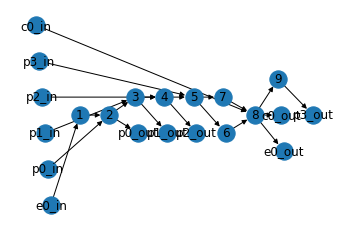

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

In [3]:
# plot the circuit as a directed, acyclic graph
circuit.draw_dag()

Now, we select a backend compiler to simulate the evolution of the quantum circuit. We currently can do this for density matrices, simulating the circuit effect by applying unitary gates.

In [4]:
from src.backends.density_matrix.compiler import DensityMatrixCompiler

compiler = DensityMatrixCompiler()
state = compiler.compile(
    circuit
)  # this returns a DensityMatrix object, and you can get underlying complex array as state.data

In [5]:
# trace out the ancilla qubit
state_a = partial_trace(state.data, keep=(0, 1, 2, 3), dims=5 * [2])

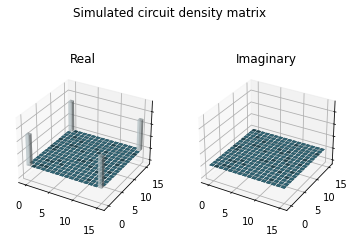

In [6]:
fig, ax = density_matrix_bars(state_a)
fig.suptitle("Simulated circuit density matrix")
plt.show()

In [7]:
# compare to the ideal density matrix
ideal_state = ket2dm(
    (tensor(4 * [state_ketz0()]) + tensor(4 * [state_ketz1()])) / np.sqrt(2)
)
f = fidelity(state_a, ideal_state)
print(f"Fidelity with ideal state: {f}")

Fidelity with ideal state: 1.0000000125303306


In [8]:
# save the resulting quantum state
from src.io import IO

io = IO.new_directory(folder="example-folder", include_date=True, include_id=True)
io.save_np_array(state_a, "partial_density_matrix.np")

30/06/2022, 10:07:25 | Saved to C:\Users\julie\Documents\_graduate\git_repositories\graph-compiler\data\2022-06-30 example-folder - 69eF\partial_density_matrix.np successfully.


Future work will build metrics (e.g., fidelity, circuit depth, success probability) and solvers (e.g., random search, decompositions, etc.), as well as other backend compilers.

In [9]:
from src import metrics
from src.solvers.evolutionary_solver import EvolutionarySolver

Iteration 0 | Best score: 0.9844


C:\Users\julie\Documents\_graduate\git_repositories\graph-compiler\src\solvers\solver_base.py:33: UserWarning: Initial circuit for EvolutionarySolver is 'None'. 
  warnings.warn(f"Initial circuit for {self.__class__.__name__} is 'None'. ")


Iteration 1 | Best score: 0.9844
Iteration 2 | Best score: 0.9844
Iteration 3 | Best score: 0.9375
Iteration 4 | Best score: 0.9375
Iteration 5 | Best score: 0.9375
Iteration 6 | Best score: 0.9375
Iteration 7 | Best score: 0.9375
Iteration 8 | Best score: 0.9375
Iteration 9 | Best score: 0.9375
Iteration 10 | Best score: 0.9375
Iteration 11 | Best score: 0.9375
Iteration 12 | Best score: 0.9375
Iteration 13 | Best score: 0.9375
Iteration 14 | Best score: 0.7500
Iteration 15 | Best score: 0.7500
Iteration 16 | Best score: 0.7500
Iteration 17 | Best score: 0.7500
Iteration 18 | Best score: 0.7500
Iteration 19 | Best score: 0.0000
Iteration 20 | Best score: 0.0000
Iteration 21 | Best score: 0.0000
Iteration 22 | Best score: 0.0000
Iteration 23 | Best score: 0.0000
Iteration 24 | Best score: 0.0000
Iteration 25 | Best score: 0.0000
Iteration 26 | Best score: 0.0000
Iteration 27 | Best score: 0.0000
Iteration 28 | Best score: 0.0000
Iteration 29 | Best score: 0.0000
Iteration 30 | Best sco

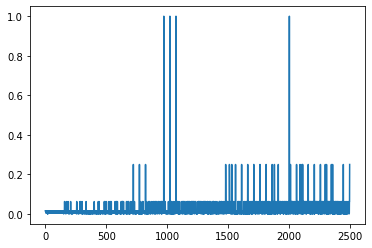

In [10]:
target = ket2dm(
    (tensor(4 * [state_ketz0()]) + tensor(4 * [state_ketz1()])) / np.sqrt(2)
)

# we pass one metric to use as the cost function. we can also pass more to be evaluated but not used as the cost
metric = metrics.Infidelity(target)

# define the solver (all methods are encapsulated in the class definition)
solver = EvolutionarySolver(
    target=target,
    metric=metric,
    compiler=compiler,
    circuit=None,
    n_emitter=1,
    n_photon=4,
)
solver.tournament_k = 0

# call .solve to implement the solver algorithm
solver.solve()

# we now have access to the metrics (don't need to pass anything back, as we are logging it in the Metric instance)
print(metric.log)

plt.plot(metric.log)
plt.show()